<a href="https://colab.research.google.com/github/kefasmanu/Data-Science/blob/main/Main_A_Comparative_Study_with_LEMNA%2C_SHAP_and_LIME__EMBER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** EMBER DATASET- Explainability in Deep Learning-based Static Malware Detection Using LEMNA: A Comparative Study with SHAP and LIME**

**LEMNA vs SHAP vs LIME: Interpreting Deep Malware Classifiers Trained on EMBER**


*Objective:* Evaluate the effectiveness of LEMNA in explaining neural network decisions on the EMBER dataset.

*Approach:*

Train a deep learning model (e.g., MLP) on the EMBER dataset.

Apply LEMNA to generate local explanations.

Compare explanation quality, faithfulness, and interpretability with SHAP and LIME.

Evaluate explanation effectiveness through quantitative metrics (fidelity, stability) and qualitative analysis (feature importance relevance to malware analysts).

*Contribution:*

Contributions of this study:
i. We propose an enhanced version of the LEMNA explainer tailored for binary feature spaces typical in malware datasets. This method includes a bit-flipping perturbation strategy that preserves semantics
more effectively than additive noise, and the integration of Bayesian Gaussian Mixture Models with Dirichlet Process priors into the LEMNA framework, allowing adaptation to the local complexity and improved modeling of nonlinear decision boundaries.

ii. We perform a systematic comparison of LEMNA, SHAP, and LIME within the deep learning-based malware detection pipeline, and evaluate each method for fidelity (RMSE, R2), robustness (cosine similarity), and consistency (Jaccard similarity).

iii. Our study reveals important trade-offs in interpretable static malware analysis: LEMNA provides the most faithful local explanations. While the three explainers are robust, LIME is the most robust, and SHAP offers a balanced trade-off, offering practical insights for method selection.

iv. We address the practical question: “When and why should LEMNA be preferred over SHAP or LIME for malware analysis?” Our findings demonstrate the value of using multiple XAI techniques to gain trustworthy interpretations in security-critical dormains.



**Import Libraries**

In [ ]:
!pip install lime

In [ ]:

# Imports important libraries
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
import lime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Comparison Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from scipy.spatial.distance import cosine # For scipy's cosine distance, 1 - distance is similarity
from lime import lime_tabular
import shap
import os
import random # For global seed consistency

import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')



Set Seeds for Reproducibility

In [ ]:
#SEED and Reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Force Device to use deterministic ops (if available)
os.environ['TF_DETERMINISTIC_OPS'] = '1'



Load Data

In [ ]:
from google.colab import drive #mouting google drive to access dataset
drive.mount('/content/drive')

EMBER Dataset

In [ ]:

# Load and Preprocess Dataset
data_path ="/content/drive/MyDrive/datasets/50f.csv" #assigning processed EMBER dataset from drive to a variable
df = pd.read_csv(data_path)
df.info()#information about the the dataset


In [ ]:
df.head()

EDA

In [ ]:
# Encode target the labels to binary*(0,1)
df['malware_benign'] = df['malware_benign'].replace({'malware': 1, 'benign': 0})
df.columns = [col.replace('-', '_') for col in df.columns]  # sanitize column names


# X:Features and y:labels
X = df.drop('malware_benign', axis=1)
y = df['malware_benign']
feature_names = X.columns.tolist()

# Train / Validation / Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)


In [ ]:
y_verify=y_val.copy

In [ ]:


# The Dense layers expect 2D input (samples, features).
# Convert pandas DataFrames to numpy arrays without reshaping
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
#X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
#y_test = y_test.to_numpy()

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

In [ ]:
print(y_val)

# Modeling and Evaluations

Decision Tree Classifier

In [ ]:
from sklearn.metrics import classification_report
# Modelling
cl = DecisionTreeClassifier(criterion='entropy', max_depth=10).fit(X_train, y_train)  # training by fitting the model with the trainingsets

# Prediction on the test set
y_predict = cl.predict(X_val)

# Classification report and confusion matrix
classification_rep_str = classification_report(y_val, y_predict)
tn, fp, fn, tp = confusion_matrix(y_val, y_predict).ravel()
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0 # Added check for division by zero

# Output
print(f"Classification Report:\n{classification_rep_str}") # Use the new variable name
print(f"False Positive Rate: {fpr:.4f}")

Logistic Regression

In [ ]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_val)

# Predict
classification_report_str = classification_report(y_val, y_pred)# Classification Report
print(f"Classification Report:\n{classification_report_str}")
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
# False Positive Rate
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
print(f"False Positive Rate: {fpr:.4f}")

XGBoost


In [ ]:
import xgboost as xgb # Import the xgboost library

#Training the XGBoost model
model=xgb.XGBClassifier(objective='binary:logistic',random_state=40)
model.fit(X_train,y_train)
#Get prediction
y_pred=model.predict(X_val) #Make predictions using the validation set

print("XGBOost Classification Report\n",classification_report(y_val,y_pred))
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
# False Positive Rate
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
print(f"False Positive Rate: {fpr:.4f}")

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier#Importing the RF classifier
classif = RandomForestClassifier(n_estimators=50).fit(X_train,y_train)#fit the model

y_pred = classif.predict(X_val)
print(confusion_matrix(y_val,y_pred))
print(accuracy_score(y_val,y_pred))
classification_report_str = classification_report(y_val, y_pred)
print(f"Classification Report:\n{classification_report_str}")
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
# False Positive Rate
fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
print(f"False Positive Rate: {fpr:.4f}")

DEEP LEARNING(MLP)

In [ ]:
#SEED and Reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
# Force Device to use deterministic ops (if available)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

#Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Model Parameters
input_size = X_train.shape[1]
hidden_size =1024 #512
output_size = 1
num_epochs = 100
learning_rate = 0.001 #0.001
batch_size = 200

# Model Architecture
model = Sequential([
    Input(shape=(input_size,)),
    Dense(hidden_size, activation='relu'),# kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.0001)),
    Dropout(0.3),
    Dense(hidden_size // 2, activation='relu'),#, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.0001)),
    Dropout(0.2),
    Dense(64, activation='relu'),#, kernel_regularizer=regularizers.l1(0.001)),
    Dropout(0.1),
    Dense(output_size, activation='sigmoid')
])

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='Precision'), Recall(name='Recall')]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# Fit and Train  the Model
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping]#, lr_scheduler
)

# Evaluate Model
loss, accuracy, precision, recall = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f},  Precision: {precision:.4f}, Recall: {recall:.4f}")

# Plot Loss Curves
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Binary Crossentropy')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.grid(True)
# plt.show()

# # Plot Accuracy Curves
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Val Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Training and Validation Accuracy')
# plt.grid(True)
# plt.show()

Evaluating MLP

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report # Import classification_report

# Predict on validation or test set
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute individual confusion matrix
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

#compute classification report
classification_report_str = classification_report(y_val, y_pred)
print(f"Classification Report:\n{classification_report_str}")

# Compute False Positive Rate
fpr = fp / (fp + tn)
print(f"False Positive Rate (FPR): {fpr:.4f}")

**Explaining the Best Performing Model(MLP) and Comparing explanation quality, faithfulness, and interpretability using LEMNA with SHAP and LIME.**

**SHAP** ANALYSIS

In [ ]:
import shap

#Create Explainer
explainer = shap.Explainer(model, shap.sample(X_train, 50))
#Compute SHAP Values
shap_values = explainer.shap_values(X_val[:50])

In [ ]:

#  Bar Plot (Feature Importance)
plt.figure(figsize=(5, 10))
shap.summary_plot(shap_values, X_val[:50],
                 feature_names=X.columns,
                 plot_type="bar",
                 show=False)
plt.title("Feature Importance (Mean SHAP Values)")
plt.tight_layout()
plt.show()


Shap Global Explanation

In [ ]:

# Box Plot (SHAP Value Distribution)
plt.figure(figsize=(5, 5))
shap.summary_plot(shap_values, X_val[:50],
                 feature_names=X.columns,
                 plot_type="dot",
                 show=False)
plt.title("SHAP Value Impacts Distribution")
plt.tight_layout()
plt.show()

SHAP Local Explanation(Instance-Wise)

In [ ]:
# WaterFall Plot (SHAP Value) Features important
plt.figure(figsize=(5, 5))

# Select a single instance to explain (e.g., the first one)
instance_index = 22
single_shap_values = shap_values[instance_index]
single_instance_features = X_val[instance_index]

# Ensuring feature names are available
feature_names = X.columns.tolist()

# Calculate the expected value manually using the model and the background data
expected_value = model.predict(shap.sample(X_train, 50)).mean()


# Use shap.plots.waterfall and pass the shap values and instance feature values
shap.plots.waterfall(shap.Explanation(values=single_shap_values,
                                     base_values=expected_value, # Use the calculated expected_value
                                     data=single_instance_features,
                                     feature_names=feature_names), show=False)

plt.title("Features Contribution for Instance " + str(instance_index))
plt.tight_layout()
plt.show()

In [ ]:
i = 3 # Index of the instance to explain
expected_value = model.predict(shap.sample(X_train, 50)).mean()

# Display force plot for one instance
shap.initjs()
shap.plots.force(
    base_value=expected_value, # Use the calculated expected value
    shap_values=shap_values[i], # Use the SHAP values for instance i
    features=X_val[i], # Use the features for instance i
    feature_names=X.columns.tolist() # Use the feature names
)

**LIME ANALYSIS**

In [ ]:
!pip install lime #Installing LIME

In [ ]:
from lime import lime_tabular#Import LIME

# Create a LIME Explainer
l_explainer = lime_tabular.LimeTabularExplainer(training_data=X_train,
                                                 feature_names=X.columns.tolist(),
                                                 class_names=['benign', 'malware'],
                                                 mode='classification')

In [ ]:
import numpy as np

# Create a LIME Explainer
l_explainer = lime_tabular.LimeTabularExplainer(training_data=X_train,
                                                 feature_names=X.columns.tolist(),
                                                 class_names=['benign', 'malware'],
                                                 mode='classification')

i=22# instance index to explain

# Wrap the model's predict method to return probabilities for both classes
def predict_proba_wrapper(data):
    # Assuming your model.predict returns the probability of the positive class (malware)
    # for a batch of data. The output shape is likely (n_samples, 1).
    malware_proba = model.predict(data)

    # Ensure malware_proba is a 2D array with shape (n_samples, 1)
    if malware_proba.ndim == 1:
        malware_proba = malware_proba.reshape(-1, 1)

    # The probability of the benign class is (1 - probability of malware)
    benign_proba = 1 - malware_proba

    # Return probabilities in the order of class_names ['benign', 'malware']
    # The output shape should be (n_samples, 2)
    return np.hstack((benign_proba, malware_proba))

# Calculate predictions for the validation set
# Assuming a threshold of 0.5 for binary classification
preds = (model.predict(X_val) > 0.5).astype(int)

#Explain the instance using LIME
#Access the i-th row using .iloc[i]
exp = l_explainer.explain_instance(data_row=X_val[i],
                                   predict_fn=predict_proba_wrapper,
                                   num_features=12) # Limit to top 10 features for clarity

#Visualize the explainer
print(f"True label: {y_val[i]}, Predicted label: {preds[i]}")
exp.show_in_notebook(show_table=True, show_all=False)

**LEMNA ANALYSIS**

In [ ]:

# LEMNA Explainer Class Definition
class LEMNAExplainer:
    """
    LEMNA Explainer for local interpretation of machine learning models.
    Adapted for binarized datasets with bit-flipping perturbation.
    """
    def __init__(self, model, n_clusters=3, alpha=0.01,
                 num_samples=2000, perturbation_strength=0.1,
                 data_type='binary', random_state=42):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.num_samples = num_samples
        self.perturbation_strength = perturbation_strength
        self.data_type = data_type
        self.random_state = random_state
        self.gmm_random_state = random_state
        self.perturbation_rng_base_seed = random_state

    # Added override parameters for flexibility in evaluation loop
    def _generate_perturbations(self, x_original, num_samples_override=None,
                                perturbation_strength_override=None, seed_offset=0):
        current_num_samples = num_samples_override if num_samples_override is not None else self.num_samples
        current_perturbation_strength = perturbation_strength_override if perturbation_strength_override is not None else self.perturbation_strength

        # Use a new RNG for each call, seeded uniquely based on x_original and seed_offset
        rng_seed = self.perturbation_rng_base_seed + seed_offset + int(np.sum(x_original) * 1000) % (2**32 -1)
        rng = np.random.default_rng(rng_seed)

        if self.data_type == 'binary':
            perturbations = np.tile(x_original, (current_num_samples, 1)).astype(np.float32)
            num_features = x_original.shape[0]
            flip_mask = rng.random(size=(current_num_samples, num_features)) < current_perturbation_strength
            perturbations[flip_mask] = 1 - perturbations[flip_mask]
            return perturbations

        elif self.data_type == 'continuous':
            perturbations = x_original + rng.normal(0, current_perturbation_strength,
                                                     size=(current_num_samples, x_original.shape[0]))
            return np.clip(perturbations, 0, 1).astype(np.float32)
        else:
            raise ValueError("data_type must be 'binary' or 'continuous'")

    def explain(self, x):
        x_reshaped = x.reshape(1, -1).astype(np.float32)
        perturbed_samples = self._generate_perturbations(x_reshaped[0])
        model_output = self.model.predict(perturbed_samples, verbose=0)

        if model_output.ndim > 1 and model_output.shape[1] > 1:
            y_preds_original_model = model_output[:, 1].flatten()
        else:
            y_preds_original_model = model_output.flatten()

        gmm = BayesianGaussianMixture(n_components=self.n_clusters, random_state=self.gmm_random_state,
                                      weight_concentration_prior_type="dirichlet_process")

        # Added try-except for GMM fitting
        try:
            clusters = gmm.fit_predict(perturbed_samples)
        except ValueError as e:
            # print(f"GMM fitting failed for an instance: {e}. Returning empty explanation for this instance.")
            return [], [], perturbed_samples, y_preds_original_model, []


        explanations = []
        local_lasso_models = []

        for cluster_id in range(self.n_clusters):
            mask = clusters == cluster_id
            X_cluster = perturbed_samples[mask]
            y_cluster = y_preds_original_model[mask]

            if X_cluster.shape[0] < 10:
                explanations.append(np.zeros_like(x, dtype=float))
                local_lasso_models.append(None)
                continue

            if self.data_type == 'continuous':
                # StandardScaler requires more than 1 sample with variance.
                # If only one sample or all samples are identical, it will fail.
                # Adding a check here.
                if X_cluster.shape[0] > 1 and np.std(X_cluster, axis=0).sum() > EPSILON_STABILITY:
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(X_cluster)
                else:
                    X_scaled = X_cluster # Cannot scale or only one unique sample
            else:
                X_scaled = X_cluster

            reg = Lasso(alpha=self.alpha, random_state=self.random_state, max_iter=5000, tol=1e-3)
            coef = np.zeros_like(x, dtype=float)
            intercept = np.mean(y_cluster) if y_cluster.size > 0 else 0.0

            if np.all(np.isclose(X_scaled, X_scaled[0, :], atol=EPSILON_STABILITY)): # Using epsilon for stability
                reg.coef_ = coef
                reg.intercept_ = intercept
            else:
                try:
                    reg.fit(X_scaled, y_cluster)
                    coef = reg.coef_
                    intercept = reg.intercept_
                except Exception as e:
                    # print(f"Lasso fitting error in cluster {cluster_id}: {e}. Coeffs set to zero.")
                    pass

            norm = np.linalg.norm(coef)
            coef_normalized = coef if norm < EPSILON_STABILITY else coef / norm # Using epsilon for stability
            explanations.append(coef_normalized)
            local_lasso_models.append(reg)

        return explanations, clusters, perturbed_samples, y_preds_original_model, local_lasso_models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score # Used for fidelity calculation

# Suppress TensorFlow verbose output if it's a Keras model
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress info and warning messages
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Define EPSILON_STABILITY for numerical comparisons
EPSILON_STABILITY = 1e-10


instance_idx = 22 # Choose an instance to explain
x_instance = X_val[instance_idx].astype(np.float32) # Ensure float32 for model input

# Instantiate LEMNAExplainer for binarized data
lemna_explainer = LEMNAExplainer(model=model,
                                 n_clusters=5, # Can tune this based on domain knowledge/experimentation
                                 alpha=0.01, # Can tune this (e.g., 0.001 to 0.1)
                                 num_samples=2000,
                                 perturbation_strength=0.05, # Probability of flipping a bit (e.g., 5%)
                                 data_type='binary', # CRUCIAL: Specifies binary perturbation
                                 random_state=42) # For overall reproducibility

# Get the full return from explain for potential fidelity calculation later
lemna_expls, clusters, perturbed_samples, y_preds_original_model, local_lasso_models = lemna_explainer.explain(x_instance)

lemna_top = np.zeros_like(x_instance, dtype=float)
lemna_local_model = None # Initialize to None for fidelity calculation

# Check if explanations were generated and find the dominant cluster's explanation
if lemna_expls and len(np.bincount(clusters)) > 0: # Ensure clusters array is not empty
    dominant_cluster_id = np.argmax(np.bincount(clusters))
    # Ensure the dominant cluster ID is valid and its explanation/model exist
    if dominant_cluster_id < len(lemna_expls) and lemna_expls[dominant_cluster_id] is not None:
        lemna_top = lemna_expls[dominant_cluster_id]
        lemna_local_model = local_lasso_models[dominant_cluster_id] if local_lasso_models and dominant_cluster_id < len(local_lasso_models) else None
    else:
        print(f"Warning: Dominant cluster {dominant_cluster_id} did not yield a valid explanation (it was None).")
else:
    print(f"Warning: No valid clusters or explanations generated for instance {instance_idx}. "
          "This might happen if all clusters are too small or no clusters formed.")

# Fidelity Calculation for this single instance (R-squared)
# Generate a new set of perturbed samples for fidelity evaluation (using bit-flipping)
fidelity_perturbation_strength = 0.02 # Small perturbation for fidelity samples (e.g., 2% bit flip)
num_fidelity_samples = 500 # Number of samples to evaluate fidelity
fidelity_test_samples = np.tile(x_instance, (num_fidelity_samples, 1)).astype(np.float32)
# Use a separate RNG for fidelity samples, optionally seeded uniquely per instance
rng_fidelity = np.random.default_rng(42 + instance_idx) # Unique seed for fidelity samples per instance
flip_mask_fidelity = rng_fidelity.random(size=(num_fidelity_samples, x_instance.shape[0])) < fidelity_perturbation_strength
fidelity_test_samples[flip_mask_fidelity] = 1 - fidelity_test_samples[flip_mask_fidelity]

# Get true model predictions on these fidelity test samples
true_model_preds_fidelity = model.predict(fidelity_test_samples, verbose=0).flatten()

lemna_fidelity_r2 = np.nan
if lemna_local_model: # Check if a valid Lasso model was obtained
    # Predict using the local Lasso model. No scaling needed for binary data_type.
    # If data_type were 'continuous', fidelity_test_samples would need to be scaled
    # using the *same* scaler instance that was used when training lemna_local_model.
    lemna_local_preds = lemna_local_model.predict(fidelity_test_samples)
    lemna_fidelity_r2 = r2_score(true_model_preds_fidelity, lemna_local_preds)
else:
    print("Fidelity could not be calculated for LEMNA due to missing local model (e.g., all clusters too small or degenerate).")

print(f"\nLEMNA Fidelity (R-squared) for instance {instance_idx}: {lemna_fidelity_r2:.4f}")

# Visualization
k = 15 # Number of top features to visualize
# Sort by absolute value to get most impactful features (positive or negative)
top_indices = np.argsort(np.abs(lemna_top))[::-1][:k]
top_features = [feature_names[i] for i in top_indices]
top_weights = lemna_top[top_indices]
top_feature_values = x_instance[top_indices]

plt.figure(figsize=(10, 6))
colors = ['skyblue' if w >= 0 else 'salmon' for w in top_weights]
plt.hlines(y=top_features, xmin=0, xmax=top_weights, color=colors, linewidth=2)
plt.plot(top_weights, top_features, "o", color='darkblue')
plt.axvline(0, color='gray', linestyle='--', alpha=0.7)

# Annotate with feature values
for i, (f_val, w) in enumerate(zip(top_feature_values, top_weights)):
    plt.text(w + 0.01 if w >= 0 else w - 0.01, i, f'{f_val:.2f}',
             va='center', ha='left' if w >= 0 else 'right', color='black', fontsize=9)

plt.title(f"LEMNA Explanation for Instance {instance_idx} (Top {k} Features)")
plt.xlabel("Feature Importance (Normalized Coefficient)")
plt.ylabel("Top Features (with Feature Values)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#5,7,9,10,19,22

**Evaluate explanation effectiveness through quantitative metrics (fidelity, stability) and qualitative analysis (feature importance relevance to malware analysts). The Metrics used are highlighted below**

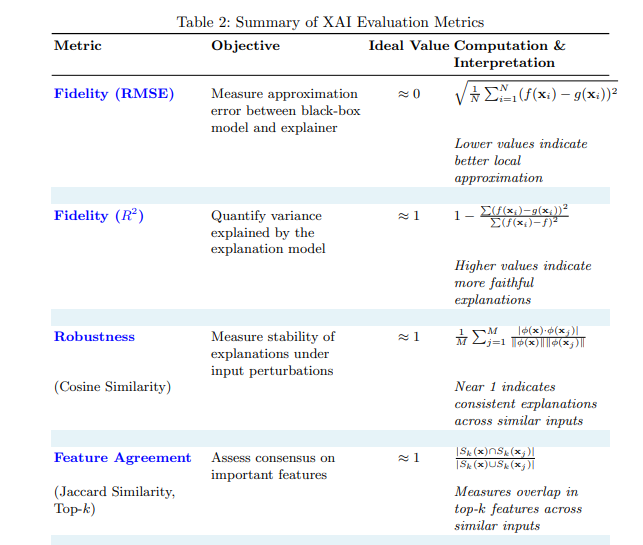

COMPARATIVE ANALYSIS OF LEMNA, LIME and SHAP

In [ ]:
#Import some important libraries
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime import lime_tabular
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.mixture import BayesianGaussianMixture # Import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:

# Suppress TensorFlow verbose output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Define EPSILON_STABILITY for numerical comparisons
EPSILON_STABILITY = 1e-10

# Global Configuration Parameters
# Set a global random state for reproducibility
GLOBAL_RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(GLOBAL_RANDOM_STATE)
random.seed(GLOBAL_RANDOM_STATE)
np.random.seed(GLOBAL_RANDOM_STATE)
tf.random.set_seed(GLOBAL_RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Evaluation parameters
NUM_INSTANCES_TO_EVALUATE = 100 # Increased for more robust aggregate metrics
FIDELITY_EVAL_SAMPLES = 500      # Number of perturbed samples for fidelity calculation
ROBUSTNESS_EVAL_SAMPLES = 500      # Number of perturbed samples for robustness (re-explanation)
TOP_K_FEATURES_JACCARD = 5       # Number of top features to consider for Jaccard similarity

# Perturbation strengths
LEMNA_PERTURB_STRENGTH = 0.05      # Probability of flipping a bit for LEMNA's internal samples
FIDELITY_PERTURB_STRENGTH = 0.02 # Probability of flipping a bit for fidelity test samples
ROBUSTNESS_PERTURB_STRENGTH = 0.01 # Probability of flipping a bit for robustness re-explanation

# Debugging flags
DEBUG_FIDELITY_VAR = True          # Print variance of true model predictions for fidelity (helps diagnose R2 issues)
DEBUG_INSTANCE_LIMIT = 5         # Limit debug prints to the first N instances
DEBUG_EXPLAINER_DETAILS = True   # Unified flag for detailed explainer debug prints (SHAP, LEMNA)


# Helper Functions

def cosine_sim(a, b):
    """Calculates cosine similarity between two vectors, handling zero vectors."""
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    if norm_a < EPSILON_STABILITY and norm_b < EPSILON_STABILITY:
        return 1.0 # Both are effectively zero, consider perfectly similar
    elif norm_a < EPSILON_STABILITY or norm_b < EPSILON_STABILITY:
        return 0.0 # One is zero, the other is not; no directional similarity
    else:
        # Use dot product for direct cosine similarity
        return np.dot(a.flatten(), b.flatten()) / (norm_a * norm_b)

def rmse(a, b):
    """Calculates Root Mean Squared Error between two vectors."""
    return np.sqrt(np.mean((a.flatten() - b.flatten()) ** 2))

# Wrapper for LIME: model.predict needs to return probabilities for both classes
def predict_proba_wrapper(data):
    malware_proba = model.predict(data, verbose=0)
    if malware_proba.ndim == 1 or malware_proba.shape[1] == 1:
        malware_proba = malware_proba.reshape(-1, 1)
    benign_proba = 1 - malware_proba
    return np.hstack((benign_proba, malware_proba))

# SHAP-specific prediction wrapper
def shap_predict_proba_single_output(data):
    """
    Wrapper for SHAP KernelExplainer to ensure a single scalar output per instance.
    Assumes model.predict returns a 2D array like [[probability]].
    """
    return model.predict(data, verbose=0).flatten() # Returns a 1D array of probabilities


# --- Helper functions to get flattened explanations and associated local models ---

def get_lemna_explanation_and_model(x, lemna_explainer_instance):
    """
    Retrieves LEMNA explanation and its corresponding local Lasso model for an instance.
    Returns flattened explanation array and the local model.
    """
    try:
        lemna_expls, clusters, _, _, local_lasso_models = lemna_explainer_instance.explain(x)
        if lemna_expls and len(clusters) > 0 and len(np.bincount(clusters)) > 0:
            dominant_cluster_id = np.argmax(np.bincount(clusters))
            if dominant_cluster_id < len(lemna_expls) and lemna_expls[dominant_cluster_id] is not None:
                explanation = lemna_expls[dominant_cluster_id].flatten()
                # Ensure local_lasso_models exists and the index is valid
                local_model = local_lasso_models[dominant_cluster_id] if local_lasso_models and dominant_cluster_id < len(local_lasso_models) else None
                return explanation, local_model
    except Exception as e:
        if DEBUG_EXPLAINER_DETAILS:
             print(f"LEMNA explanation or model retrieval error: {e}")
        pass # Handle cases where LEMNA might fail to produce an explanation

    # Return zeros and None if no valid explanation or model found
    return np.zeros_like(x).flatten(), None


def get_shap_explanation_flattened(x, shap_explainer_instance):
    """Retrieves SHAP explanation for an instance, returns flattened array."""
    try:
        if not callable(shap_explainer_instance):
            if DEBUG_EXPLAINER_DETAILS:
                print(f"Error: SHAP explainer object is not callable. Type found: {type(shap_explainer_instance)}")
            return np.zeros_like(x).flatten()

        shap_exp = shap_explainer_instance(x.reshape(1, -1)) # Call the explainer

        if shap_exp.values.ndim == 2 and shap_exp.values.shape[0] == 1:
            return shap_exp.values[0, :].flatten()
        else:
            return shap_exp.values.flatten()

    except Exception as e:
        if DEBUG_EXPLAINER_DETAILS:
            print(f"An unexpected error occurred during SHAP explanation for instance: {e}")
        return np.zeros_like(x).flatten()


def get_lime_explanation_and_intercept(x, lime_explainer_instance):
    """
    Retrieves LIME explanation for an instance, returns flattened array and intercept.
    This re-runs LIME to get the full explanation object including intercept.
    """
    pred_class = np.argmax(predict_proba_wrapper(x.reshape(1, -1)))
    try:
        lime_exp = lime_explainer_instance.explain_instance(
            x,
            predict_proba_wrapper,
            num_features=len(x),
            num_samples=20000 # Adjusted this value as discussed
        )
        lime_weights = np.zeros_like(x).flatten()
        lime_map = lime_exp.as_map()
        # Intercept for the positive class (index 1 assuming predict_proba_wrapper returns [benign, malware]
        lime_intercept = lime_exp.intercept[1]

        lime_class_to_explain = pred_class if pred_class in lime_map and lime_map[pred_class] else (list(lime_map.keys())[0] if lime_map else None)

        if lime_class_to_explain is not None:
            for feat, weight in lime_map.get(lime_class_to_explain, []):
                if feat < len(lime_weights): # Ensure index is within bounds
                    lime_weights[feat] = weight
        return lime_weights, lime_intercept
    except Exception as e:
        if DEBUG_EXPLAINER_DETAILS:
            print(f"LIME explanation error: {e}")
        return np.zeros_like(x).flatten(), 0.0


def get_top_k_indices(explanation, k):
    """Returns indices of top K features by absolute importance from an explanation vector."""
    if explanation is None or np.linalg.norm(explanation) < EPSILON_STABILITY:
        return set()
    actual_k = min(k, len(explanation))
    # Using np.argpartition for potentially faster partial sort if k is much smaller than len(explanation)
    # Then argsort the top k for ordered output
    top_indices = np.argpartition(np.abs(explanation), -actual_k)[-actual_k:]
    # Sort these top_indices by their corresponding absolute values in descending order
    sorted_top_indices = top_indices[np.argsort(np.abs(explanation)[top_indices])][::-1]
    return set(sorted_top_indices)

def jaccard_similarity_sets(set1, set2):
    """Calculates Jaccard Similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0.0 # Avoid division by zero if both sets are empty
    return intersection / union

# --- NEW HELPER FUNCTION FOR PLOTTING ---
def get_feature_labels_with_values(feature_names, feature_values, top_indices):
    """
    Creates a list of formatted strings for top features, including their original values.
    Rounds float values for cleaner display.
    """
    labels = []
    for idx in top_indices:
        feature_name = feature_names[idx]
        feature_value = feature_values[idx]
        # Assuming boolean-like values (0 or 1), so int conversion is fine
        display_value = f"{int(feature_value)}"
        labels.append(f"{feature_name} (Value: {display_value})")
    return labels

# --- LEMNA Explainer Class Definition (Updated) ---
class LEMNAExplainer:
    """
    LEMNA Explainer for local interpretation of machine learning models.
    Adapted for binarized datasets with bit-flipping perturbation.
    """
    def __init__(self, model, n_clusters=3, alpha=0.01,
                 num_samples=2000, perturbation_strength=0.1,
                 data_type='binary', random_state=42):
        self.model = model
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.num_samples = num_samples
        self.perturbation_strength = perturbation_strength
        self.data_type = data_type
        self.random_state = random_state
        self.gmm_random_state = random_state
        self.perturbation_rng_base_seed = random_state

    # Added override parameters for flexibility in evaluation loop
    def _generate_perturbations(self, x_original, num_samples_override=None,
                                 perturbation_strength_override=None, seed_offset=0):
        current_num_samples = num_samples_override if num_samples_override is not None else self.num_samples
        current_perturbation_strength = perturbation_strength_override if perturbation_strength_override is not None else self.perturbation_strength

        # Use a new RNG for each call, seeded uniquely based on x_original and seed_offset
        rng_seed = self.perturbation_rng_base_seed + seed_offset + int(np.sum(x_original) * 1000) % (2**32 -1)
        rng = np.random.default_rng(rng_seed)

        if self.data_type == 'binary':
            perturbations = np.tile(x_original, (current_num_samples, 1)).astype(np.float32)
            num_features = x_original.shape[0]
            flip_mask = rng.random(size=(current_num_samples, num_features)) < current_perturbation_strength
            perturbations[flip_mask] = 1 - perturbations[flip_mask]
            return perturbations

        elif self.data_type == 'continuous':
            perturbations = x_original + rng.normal(0, current_perturbation_strength,
                                                     size=(current_num_samples, x_original.shape[0]))
            return np.clip(perturbations, 0, 1).astype(np.float32)
        else:
            raise ValueError("data_type must be 'binary' or 'continuous'")

    def explain(self, x):
        x_reshaped = x.reshape(1, -1).astype(np.float32)
        perturbed_samples = self._generate_perturbations(x_reshaped[0])
        model_output = self.model.predict(perturbed_samples, verbose=0)

        if model_output.ndim > 1 and model_output.shape[1] > 1:
            y_preds_original_model = model_output[:, 1].flatten()
        else:
            y_preds_original_model = model_output.flatten()

        gmm = BayesianGaussianMixture(n_components=self.n_clusters, random_state=self.gmm_random_state,
                                     weight_concentration_prior_type="dirichlet_process")

        # Added try-except for GMM fitting
        try:
            clusters = gmm.fit_predict(perturbed_samples)
        except ValueError as e:
            # print(f"GMM fitting failed for an instance: {e}. Returning empty explanation for this instance.")
            return [], [], perturbed_samples, y_preds_original_model, []


        explanations = []
        local_lasso_models = []

        for cluster_id in range(self.n_clusters):
            mask = clusters == cluster_id
            X_cluster = perturbed_samples[mask]
            y_cluster = y_preds_original_model[mask]

            if X_cluster.shape[0] < 10:
                explanations.append(np.zeros_like(x, dtype=float))
                local_lasso_models.append(None)
                continue

            if self.data_type == 'continuous':
                # StandardScaler requires more than 1 sample with variance.
                # If only one sample or all samples are identical, it will fail.
                # Adding a check here.
                if X_cluster.shape[0] > 1 and np.std(X_cluster, axis=0).sum() > EPSILON_STABILITY:
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(X_cluster)
                else:
                    X_scaled = X_cluster # Cannot scale or only one unique sample
            else:
                X_scaled = X_cluster

            reg = Lasso(alpha=self.alpha, random_state=self.random_state, max_iter=5000, tol=1e-3)
            coef = np.zeros_like(x, dtype=float)
            intercept = np.mean(y_cluster) if y_cluster.size > 0 else 0.0

            if np.all(np.isclose(X_scaled, X_scaled[0, :], atol=EPSILON_STABILITY)): # Using epsilon for stability
                reg.coef_ = coef
                reg.intercept_ = intercept
            else:
                try:
                    reg.fit(X_scaled, y_cluster)
                    coef = reg.coef_
                    intercept = reg.intercept_
                except Exception as e:
                    # print(f"Lasso fitting error in cluster {cluster_id}: {e}. Coeffs set to zero.")
                    pass

            norm = np.linalg.norm(coef)
            coef_normalized = coef if norm < EPSILON_STABILITY else coef / norm # Using epsilon for stability
            explanations.append(coef_normalized)
            local_lasso_models.append(reg)

        return explanations, clusters, perturbed_samples, y_preds_original_model, local_lasso_models


#  Use X.columns for feature names
# Moved this definition after X is created
feature_names = X.columns.tolist()
print(f"Feature names loaded: {feature_names[:5]}...") # Print first 5 to confirm


print("--- Initializing Explainers ---")

# SHAP Explainer
shap_background_data = shap.sample(X_train, 200) # Increased from 50
shap_explainer = shap.Explainer(shap_predict_proba_single_output, shap_background_data)
shap_expected_value = shap_predict_proba_single_output(shap_background_data).mean()
print("SHAP Explainer initialized.")

# LIME Explainer
l_explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, # LIME expects numpy array for training_data
                                                 feature_names=feature_names,
                                                 class_names=['benign', 'malware'],
                                                 mode='classification',
                                                 discretize_continuous=False,
                                                 random_state=GLOBAL_RANDOM_STATE)
print("LIME Explainer initialized.")

# LEMNA Explainer
lemna_explainer = LEMNAExplainer(model=model,
                                 n_clusters=5,
                                 alpha=0.01, # You might tune this if your actual LEMNA uses Lasso
                                 num_samples=2000,
                                 perturbation_strength=LEMNA_PERTURB_STRENGTH,
                                 data_type='binary', # Ensure this matches your actual data
                                 random_state=GLOBAL_RANDOM_STATE)
print("LEMNA Explainer initialized.")


# --- Data Structures for Storing Metrics ---
lemna_r2_scores = []
lemna_rmse_scores = []
lemna_robustness_scores = []

lime_r2_scores = []
lime_rmse_scores = []
lime_robustness_scores = []

shap_r2_scores = []
shap_rmse_scores = []
shap_robustness_scores = []

lemna_lime_jaccard_scores = []
lemna_shap_jaccard_scores = []
lime_shap_jaccard_scores = []


#  Main Evaluation Loop (Aggregate Metrics)
print(f"\n--- Starting Aggregate Evaluation for {NUM_INSTANCES_TO_EVALUATE} Instances ---")
for i in range(NUM_INSTANCES_TO_EVALUATE):
    x_instance = X_val[i].astype(np.float32) # Corrected to use numpy indexing
    original_model_pred_prob = model.predict(x_instance.reshape(1, -1), verbose=0)[0, 0]

    if i < DEBUG_INSTANCE_LIMIT:
        print(f"\nProcessing instance {i+1}/{NUM_INSTANCES_TO_EVALUATE} (Original Pred: {original_model_pred_prob:.4f})")

    # 1. Generate Explanations
    lemna_explanation, lemna_local_model_for_fidelity = get_lemna_explanation_and_model(x_instance, lemna_explainer)
    shap_explanation = get_shap_explanation_flattened(x_instance, shap_explainer)
    lime_explanation, lime_intercept_for_fidelity = get_lime_explanation_and_intercept(x_instance, l_explainer)

    # NEW: Debug prints for explainer explanations (unified under DEBUG_EXPLAINER_DETAILS)
    if DEBUG_EXPLAINER_DETAILS and i < DEBUG_INSTANCE_LIMIT:
        print(f"   --- SHAP Debug for instance {i+1} ---")
        print(f"   Raw SHAP explanation (first 10 values): {shap_explanation[:10]}")
        print(f"   Norm of SHAP explanation: {np.linalg.norm(shap_explanation):.4e}")
        print(f"   SHAP Expected Value: {shap_expected_value:.4f}")
        print(f"   Original Model Pred: {original_model_pred_prob:.4f}")
        print(f"   Difference (Pred - Expected): {original_model_pred_prob - shap_expected_value:.4f}")
        print(f"   Sum of SHAP values: {np.sum(shap_explanation):.4f}")
        # KernelSHAP additivity check: sum(shap_values) + expected_value approx original_prediction
        print(f"   Additivity Check (Sum SHAP + Expected - Pred): {(np.sum(shap_explanation) + shap_expected_value - original_model_pred_prob):.4e}")
        print(f"   --------------------------")

        print(f"   --- LEMNA Debug for instance {i+1} ---")
        print(f"   Raw LEMNA explanation (first 10 values): {lemna_explanation[:10]}")
        print(f"   Norm of LEMNA explanation: {np.linalg.norm(lemna_explanation):.4e}")
        if lemna_local_model_for_fidelity:
            try:
                lemna_local_pred_on_original = lemna_local_model_for_fidelity.predict(x_instance.reshape(1, -1))[0]
                print(f"   LEMNA Local Model Pred on Original Instance: {lemna_local_pred_on_original:.4f}")
                print(f"   Difference (LEMNA Local Pred - Original Pred): {(lemna_local_pred_on_original - original_model_pred_prob):.4f}")
            except Exception as e:
                print(f"   Error predicting with LEMNA local model on original instance: {e}")
        else:
            print("   LEMNA local model was None for this instance (likely couldn't fit).")
        print(f"   --------------------------")


    # 2. Fidelity Calculation (R2 and RMSE)
    fidelity_test_samples = lemna_explainer._generate_perturbations(
        x_instance,
        num_samples_override=FIDELITY_EVAL_SAMPLES,
        perturbation_strength_override=FIDELITY_PERTURB_STRENGTH,
        seed_offset=i + 1 # Unique seed for fidelity samples per instance
    )
    true_model_preds_fidelity = model.predict(fidelity_test_samples, verbose=0).flatten()

    if DEBUG_FIDELITY_VAR and i < DEBUG_INSTANCE_LIMIT:
        print(f"   True Model Preds (Fidelity Samples) Mean: {np.mean(true_model_preds_fidelity):.4f}")
        print(f"   True Model Preds (Fidelity Samples) Var: {np.var(true_model_preds_fidelity):.4e}")
        print(f"   True Model Preds (Fidelity Samples) Min/Max: {np.min(true_model_preds_fidelity):.4f} / {np.max(true_model_preds_fidelity):.4f}")

    # LEMNA Fidelity
    if lemna_local_model_for_fidelity:
        try:
            lemna_local_preds = lemna_local_model_for_fidelity.predict(fidelity_test_samples)
            lemna_r2_scores.append(r2_score(true_model_preds_fidelity, lemna_local_preds))
            lemna_rmse_scores.append(rmse(true_model_preds_fidelity, lemna_local_preds))
        except Exception as e:
            if i < DEBUG_INSTANCE_LIMIT: print(f"   LEMNA Fidelity prediction error: {e}")
            lemna_r2_scores.append(np.nan)
            lemna_rmse_scores.append(np.nan)
    else:
        lemna_r2_scores.append(np.nan)
        lemna_rmse_scores.append(np.nan)

    # LIME Fidelity
    try:
        if np.linalg.norm(lime_explanation) > EPSILON_STABILITY or abs(lime_intercept_for_fidelity) > EPSILON_STABILITY:
            lime_local_preds = np.dot(fidelity_test_samples, lime_explanation) + lime_intercept_for_fidelity
            lime_r2_scores.append(r2_score(true_model_preds_fidelity, lime_local_preds))
            lime_rmse_scores.append(rmse(true_model_preds_fidelity, lime_local_preds))
        else:
            if i < DEBUG_INSTANCE_LIMIT: print(f"   LIME explanation or intercept near zero for fidelity.")
            lime_r2_scores.append(np.nan)
            lime_rmse_scores.append(np.nan)
    except Exception as e:
        if i < DEBUG_INSTANCE_LIMIT: print(f"   LIME Fidelity calculation error: {e}")
        lime_r2_scores.append(np.nan)
        lime_rmse_scores.append(np.nan)

    # SHAP Fidelity
    try:
        if np.linalg.norm(shap_explanation) > EPSILON_STABILITY or abs(shap_expected_value) > EPSILON_STABILITY:
            shap_local_preds = np.dot(fidelity_test_samples, shap_explanation) + shap_expected_value
            shap_r2_scores.append(r2_score(true_model_preds_fidelity, shap_local_preds))
            shap_rmse_scores.append(rmse(true_model_preds_fidelity, shap_local_preds))
        else:
            if i < DEBUG_INSTANCE_LIMIT: print(f"   SHAP explanation or expected value near zero for fidelity.")
            shap_r2_scores.append(np.nan)
            shap_rmse_scores.append(np.nan)
    except Exception as e:
        if i < DEBUG_INSTANCE_LIMIT: print(f"   SHAP Fidelity calculation error: {e}")
        shap_r2_scores.append(np.nan)
        shap_rmse_scores.append(np.nan)


    #  Robustness Calculation (Cosine Similarity) ---
    perturbed_x_for_robustness = lemna_explainer._generate_perturbations(
        x_instance,
        num_samples_override=1, # Generate just one perturbed sample for robustness re-explanation
        perturbation_strength_override=ROBUSTNESS_PERTURB_STRENGTH,
        seed_offset=i + 2 # Unique seed for robustness sample per instance
    )[0]

    lemna_explanation_p, _ = get_lemna_explanation_and_model(perturbed_x_for_robustness, lemna_explainer)
    shap_explanation_p = get_shap_explanation_flattened(perturbed_x_for_robustness, shap_explainer)
    lime_explanation_p, _ = get_lime_explanation_and_intercept(perturbed_x_for_robustness, l_explainer)

    lemna_robustness_scores.append(cosine_sim(lemna_explanation, lemna_explanation_p))
    lime_robustness_scores.append(cosine_sim(lime_explanation, lime_explanation_p))
    shap_robustness_scores.append(cosine_sim(shap_explanation, shap_explanation_p))


    # Jaccard Similarity (Top K Features) ---
    lemna_top_k_indices = get_top_k_indices(lemna_explanation, TOP_K_FEATURES_JACCARD)
    lime_top_k_indices = get_top_k_indices(lime_explanation, TOP_K_FEATURES_JACCARD)
    shap_top_k_indices = get_top_k_indices(shap_explanation, TOP_K_FEATURES_JACCARD)

    lemna_lime_jaccard_scores.append(jaccard_similarity_sets(lemna_top_k_indices, lime_top_k_indices))
    lemna_shap_jaccard_scores.append(jaccard_similarity_sets(lemna_top_k_indices, shap_top_k_indices))
    lime_shap_jaccard_scores.append(jaccard_similarity_sets(lime_top_k_indices, shap_top_k_indices))


# Aggregate Evaluation Summary Table ---
print("\n--- Aggregate Explanation Evaluation Summary ---")

summary_data = {
    'Explainer': ['LEMNA', 'LIME', 'SHAP'],
    'Mean Fidelity (RMSE)': [np.nanmean(lemna_rmse_scores), np.nanmean(lime_rmse_scores), np.nanmean(shap_rmse_scores)],
    'Std Dev Fidelity (RMSE)': [np.nanstd(lemna_rmse_scores), np.nanstd(lime_rmse_scores), np.nanstd(shap_rmse_scores)],
    'Mean Robustness (Cosine Sim)': [np.nanmean(lemna_robustness_scores), np.nanmean(lime_robustness_scores), np.nanmean(shap_robustness_scores)],
    'Std Dev Robustness (Cosine Sim)': [np.nanstd(lemna_robustness_scores), np.nanstd(lime_robustness_scores), np.nanstd(shap_robustness_scores)],
    'Mean Jaccard (LEMNA-LIME)': [np.nanmean(lemna_lime_jaccard_scores), np.nan, np.nan],
    'Mean Jaccard (LEMNA-SHAP)': [np.nanmean(lemna_shap_jaccard_scores), np.nan, np.nan],
    'Mean Jaccard (LIME-SHAP)': [np.nanmean(lime_shap_jaccard_scores), np.nan, np.nan],
}

# For Top Features, pick an example from the last processed instance if available
# Use the explanations from the very last instance processed by the loop
# These variables should already hold the values from the last loop iteration.
# Added checks for None in case an explainer failed for the last instance
lemna_explanation_final = lemna_explanation if 'lemna_explanation' in locals() else None
lime_explanation_final = lime_explanation if 'lime_explanation' in locals() else None
shap_explanation_final = shap_explanation if 'shap_explanation' in locals() else None

example_top_features_lemna = [feature_names[idx] for idx in get_top_k_indices(lemna_explanation_final, 5)]
example_top_features_lime = [feature_names[idx] for idx in get_top_k_indices(lime_explanation_final, 5)]
example_top_features_shap = [feature_names[idx] for idx in get_top_k_indices(shap_explanation_final, 5)]


summary_data['Top Features (Example)'] = [
    example_top_features_lemna,
    example_top_features_lime,
    example_top_features_shap
]

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string())


# --- Aggregate Plots (Box Plots) ---
print("\n----Generating Aggregate Plots ---")

metrics_to_plot = {
    'Fidelity (RMSE)': {
        'LEMNA': lemna_rmse_scores,
        'LIME': lime_rmse_scores,
        'SHAP': shap_rmse_scores
    },
    'Robustness (Cosine Sim)': {
        'LEMNA': lemna_robustness_scores,
        'LIME': lime_robustness_scores,
        'SHAP': shap_robustness_scores
    }
}

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(7 * len(metrics_to_plot), 6))
axes = axes.flatten()

for i, (metric_name, scores_dict) in enumerate(metrics_to_plot.items()):
    # Filter out None/NaN values before creating DataFrame for plotting
    cleaned_scores = {key: [score for score in scores_list if score is not None and not np.isnan(score)] for key, scores_list in scores_dict.items()}

    # Combine cleaned scores into a single list for the DataFrame
    all_scores = []
    explainer_names = []
    for explainer, scores_list in cleaned_scores.items():
        all_scores.extend(scores_list)
        explainer_names.extend([explainer] * len(scores_list))

    plot_df = pd.DataFrame({
        'Explainer': explainer_names,
        'Score': all_scores
    })

    if not plot_df.empty: # Only plot if there's data after cleaning
        sns.boxplot(x='Explainer', y='Score', data=plot_df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'{metric_name} Distribution')
        axes[i].set_ylabel(metric_name)
        axes[i].set_ylim(0, 1) if "Cosine Sim" in metric_name else axes[i].set_ylim(bottom=0)
    else:
        axes[i].set_title(f'{metric_name} Distribution (No Data)')
        axes[i].text(0.5, 0.5, "No valid scores to plot", horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)


plt.tight_layout()
plt.show()

# Jaccard Similarity Bar Plot
jaccard_data = {
    'Comparison': ['LEMNA-LIME', 'LEMNA-SHAP', 'LIME-SHAP'],
    'Mean Jaccard Similarity': [
        np.nanmean(lemna_lime_jaccard_scores),
        np.nanmean(lemna_shap_jaccard_scores),
        np.nanmean(lime_shap_jaccard_scores)
    ]
}
jaccard_df = pd.DataFrame(jaccard_data)
plt.figure(figsize=(8, 5))
sns.barplot(x='Comparison', y='Mean Jaccard Similarity', data=jaccard_df, palette='cividis')
plt.title(f'Mean Jaccard Similarity of Top {TOP_K_FEATURES_JACCARD} Features')
plt.ylabel('Mean Jaccard Similarity')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


# Detailed Local Instance Comparison ---
print("\n--- Detailed Local Instance Comparison ---")

interesting_instance_indices = [5, 19, 22] # Choose a few instances for detailed comparison.#5,7,9,10,19,22

for instance_idx in interesting_instance_indices:
    if instance_idx >= NUM_INSTANCES_TO_EVALUATE:
        print(f"Skipping instance {instance_idx}: Index out of range evaluated ({NUM_INSTANCES_TO_EVALUATE}).")
        continue

    x_instance_local = X_val[instance_idx].astype(np.float32) # Corrected to use numpy indexing
    original_model_pred_local = model.predict(x_instance_local.reshape(1, -1), verbose=0)[0, 0]
    print(f"\nAnalyzing Instance Index: {instance_idx} (Original Prediction: {original_model_pred_local:.4f})")

    # Re-generate explanations for this specific instance for local details
    lemna_explanation_local, lemna_local_model_for_fidelity_local = get_lemna_explanation_and_model(x_instance_local, lemna_explainer)
    shap_explanation_local = get_shap_explanation_flattened(x_instance_local, shap_explainer)
    lime_explanation_local, lime_intercept_for_fidelity_local = get_lime_explanation_and_intercept(x_instance_local, l_explainer)


    # Local Fidelity Metrics ---
    fidelity_test_samples_local = lemna_explainer._generate_perturbations(
        x_instance_local,
        num_samples_override=FIDELITY_EVAL_SAMPLES,
        perturbation_strength_override=FIDELITY_PERTURB_STRENGTH,
        seed_offset=instance_idx + 2000 # Unique seed for local fidelity
    )
    true_model_preds_fidelity_local = model.predict(fidelity_test_samples_local, verbose=0).flatten()

    lemna_local_r2 = np.nan
    lemna_local_rmse = np.nan
    if lemna_local_model_for_fidelity_local:
        try:
            lemna_local_preds = lemna_local_model_for_fidelity_local.predict(fidelity_test_samples_local)
            lemna_local_r2 = r2_score(true_model_preds_fidelity_local, lemna_local_preds)
            lemna_local_rmse = rmse(true_model_preds_fidelity_local, lemna_local_preds)
        except Exception as e:
            if DEBUG_EXPLAINER_DETAILS: print(f"   LEMNA Local Fidelity prediction error: {e}")

    lime_local_r2 = np.nan
    lime_local_rmse = np.nan
    try:
        if np.linalg.norm(lime_explanation_local) > EPSILON_STABILITY or abs(lime_intercept_for_fidelity_local) > EPSILON_STABILITY:
            lime_local_preds = np.dot(fidelity_test_samples_local, lime_explanation_local) + lime_intercept_for_fidelity_local
            lime_local_r2 = r2_score(true_model_preds_fidelity_local, lime_local_preds)
            lime_local_rmse = rmse(true_model_preds_fidelity_local, lime_local_preds)
    except Exception as e:
        if DEBUG_EXPLAINER_DETAILS: print(f"   LIME Local Fidelity calculation error: {e}")


    shap_local_r2 = np.nan
    shap_local_rmse = np.nan
    # Use shap_expected_value from global context for local SHAP fidelity
    try:
        if np.linalg.norm(shap_explanation_local) > EPSILON_STABILITY or abs(shap_expected_value) > EPSILON_STABILITY:
            shap_local_preds = np.dot(fidelity_test_samples_local, shap_explanation_local) + shap_expected_value
            shap_local_r2 = r2_score(true_model_preds_fidelity_local, shap_local_preds)
            shap_local_rmse = rmse(true_model_preds_fidelity_local, shap_local_preds)
    except Exception as e:
        if DEBUG_EXPLAINER_DETAILS: print(f"   SHAP Local Fidelity calculation error: {e}")


    print(f"   Local R2 Scores: LEMNA={lemna_local_r2:.4f}, LIME={lime_local_r2:.4f}, SHAP={shap_local_r2:.4f}")
    print(f"   Local RMSE Scores: LEMNA={lemna_local_rmse:.4f}, LIME={lime_local_rmse:.4f}, SHAP={shap_local_rmse:.4f}")

    #  Local Robustness
    perturbed_x_local = lemna_explainer._generate_perturbations(
        x_instance_local,
        num_samples_override=1,
        perturbation_strength_override=ROBUSTNESS_PERTURB_STRENGTH,
        seed_offset=instance_idx + 3000
    )[0]

    lemna_explanation_p_local, _ = get_lemna_explanation_and_model(perturbed_x_local, lemna_explainer)
    shap_explanation_p_local = get_shap_explanation_flattened(perturbed_x_local, shap_explainer)
    lime_explanation_p_local, _ = get_lime_explanation_and_intercept(perturbed_x_local, l_explainer)

    lemna_robust_local = cosine_sim(lemna_explanation_local, lemna_explanation_p_local)
    lime_robust_local = cosine_sim(lime_explanation_local, lime_explanation_p_local)
    shap_robust_local = cosine_sim(shap_explanation_local, shap_explanation_p_local)

    print(f"   Local Robustness Scores (Cosine Sim): LEMNA={lemna_robust_local:.4f}, LIME={lime_robust_local:.4f}, SHAP={shap_robust_local:.4f}")

    # Plotting the explanations for the instance ---
    # Retrieve top K features and their weights
    num_top_features_to_plot = 10
    top_k_indices_lemna = list(get_top_k_indices(lemna_explanation_local, num_top_features_to_plot))
    top_k_indices_lime = list(get_top_k_indices(lime_explanation_local, num_top_features_to_plot))
    top_k_indices_shap = list(get_top_k_indices(shap_explanation_local, num_top_features_to_plot))

    lemna_weights = lemna_explanation_local[top_k_indices_lemna]
    lime_weights = lime_explanation_local[top_k_indices_lime]
    shap_weights = shap_explanation_local[top_k_indices_shap]

    # Sort weights and indices in descending order of absolute value for consistent plotting
    lemna_sorted_indices = np.argsort(np.abs(lemna_weights))[::-1]
    lime_sorted_indices = np.argsort(np.abs(lime_weights))[::-1]
    shap_sorted_indices = np.argsort(np.abs(shap_weights))[::-1]

    top_k_indices_lemna = np.array(top_k_indices_lemna)[lemna_sorted_indices]
    top_k_indices_lime = np.array(top_k_indices_lime)[lime_sorted_indices]
    top_k_indices_shap = np.array(top_k_indices_shap)[shap_sorted_indices]

    lemna_weights = lemna_weights[lemna_sorted_indices]
    lime_weights = lime_weights[lime_sorted_indices]
    shap_weights = shap_weights[shap_sorted_indices]

    # Get feature labels with boolean values
    lemna_labels = get_feature_labels_with_values(feature_names, x_instance_local, top_k_indices_lemna)
    lime_labels = get_feature_labels_with_values(feature_names, x_instance_local, top_k_indices_lime)
    shap_labels = get_feature_labels_with_values(feature_names, x_instance_local, top_k_indices_shap)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
    fig.suptitle(f'Top {num_top_features_to_plot} Feature Explanations for Instance {instance_idx}\n'
                 f'(Original Prediction: {original_model_pred_local:.4f})', fontsize=16)

    sns.barplot(x=lemna_weights, y=lemna_labels, ax=axes[0], palette='coolwarm')
    axes[0].set_title('LEMNA Explanation')
    axes[0].set_xlabel('Feature Importance')

    sns.barplot(x=lime_weights, y=lime_labels, ax=axes[1], palette='coolwarm')
    axes[1].set_title('LIME Explanation')
    axes[1].set_xlabel('Feature Importance')

    sns.barplot(x=shap_weights, y=shap_labels, ax=axes[2], palette='coolwarm')
    axes[2].set_title('SHAP Explanation')
    axes[2].set_xlabel('Feature Importance')

    for ax in axes:
        ax.axvline(0, color='black', linewidth=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Summary of Evaluation

In [ ]:
summary_df

Inter-explainaer  Agreeme Plot

In [ ]:
# Jaccard Similarity Bar Plot
jaccard_data = {
    'Comparison': ['LEMNA-LIME', 'LEMNA-SHAP', 'LIME-SHAP'],
    'Mean Jaccard Similarity': [
        np.nanmean(lemna_lime_jaccard_scores),
        np.nanmean(lemna_shap_jaccard_scores),
        np.nanmean(lime_shap_jaccard_scores)
    ]
}
jaccard_df = pd.DataFrame(jaccard_data)
plt.figure(figsize=(8, 5))
sns.barplot(x='Comparison', y='Mean Jaccard Similarity', data=jaccard_df, palette='cividis')
plt.title(f'Mean Jaccard Similarity of Top {TOP_K_FEATURES_JACCARD} Features')
plt.ylabel('Mean Jaccard Similarity')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
